<a href="https://colab.research.google.com/github/bhavesh3002/PORTFOLIO/blob/main/DigMktA_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Business Context:**

A marketing company is conducting an A/B test to evaluate the effectiveness of their advertising campaign. The test compares user behavior between those who saw advertisements (Ad group) versus those who saw public service announcements (PSA group).

Key Questions to Address:

**1. Campaign Effectiveness:**

1. What is the conversion lift attributable to the advertising?
2. Is there a statistically significant difference in conversion rates between ad and PSA groups?
3. What is the effect size (how much better/worse did the ad group perform)?
4. What is the confidence interval for difference in conversion rates if it exists?

**2. ROI(Return on Investment) Assessment:**

1. How much additional revenue can be expected from using ads vs PSAs?

**3. Ad Exposure Impact:**

1. Is there a correlation between the number of ads seen and conversion rate?
2. What is the optimal number of ad exposures for conversion?

**4. Temporal Analysis:**

1. Which days of the week show the highest conversion rates?
2. Is the a significant difference in conversion between weekdays?
3. What are the most effective day of week for ad display?
4. Is there a significant difference in ad performance across different times?
5. What are the most effective hours for ad display?



**Expected Outcomes:**

1. Statistical validation of campaign effectiveness
2. Quantified business impact with confidence intervals
3. Recommendations for optimal ad delivery timing
4. Insights for future campaign optimization

**Data dictionary:**




* index: Row index
* user_id: user_id (unique)
* test_group: If "ad" the person saw the advertisement, if "psa" they only saw * default public service announcement
* converted: If a person bought the product then True, else is False
* total_ads: Amount of ads seen by person
* most_ads_day: Day that the person saw the biggest amount of ads
* most_ads_hour: Hour of day that the person saw the biggest amount of ads

In [3]:
# Data
import pandas as pd
import numpy as np
from itertools import combinations
import random

# A/B testing
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import confint_proportions_2indep
from statsmodels.stats.power import NormalIndPower
from scipy.stats import chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import logit
from scipy.optimize import minimize
from sklearn.metrics import roc_auc_score

# Suppress specific warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.patches import Patch

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

%config InlineBackend.figure_format='retina'

# Custom color palette
custom_colors = ['#F6BD60', '#F7EDE2', '#F5CAC3', '#84A59D', '#F28482']

sns.set_theme(context='paper', style='whitegrid', palette=custom_colors, font='sans-serif', font_scale=1, color_codes=True,
              rc={'grid.alpha': 0.5, 'axes.titlesize': 14, 'figure.figsize': (12, 6)})

sns.color_palette(custom_colors)

[(0.9647058823529412, 0.7411764705882353, 0.3764705882352941),
 (0.9686274509803922, 0.9294117647058824, 0.8862745098039215),
 (0.9607843137254902, 0.792156862745098, 0.7647058823529411),
 (0.5176470588235295, 0.6470588235294118, 0.615686274509804),
 (0.9490196078431372, 0.5176470588235295, 0.5098039215686274)]

In [4]:
ad_campaign = pd.read_csv('marketing_AB.csv')
ad_campaign.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


# EDA

In [5]:
ad_campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


Consistency Check

In [ ]:
# Check unique weekdays
ad_campaign['most ads day'].unique()

array(['Monday', 'Tuesday', 'Friday', 'Saturday', 'Wednesday', 'Sunday',
       'Thursday'], dtype=object)

In [ ]:
# Check unique hours
np.sort(ad_campaign['most ads hour'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [ ]:
# Check test_groups
ad_campaign['test group'].unique()

array(['ad', 'psa'], dtype=object)

Missing Values Check

In [6]:
ad_campaign.isna().sum()

,0
Unnamed: 0,0
user id,0
test group,0
converted,0
total ads,0
most ads day,0
most ads hour,0


**Outliers Investigation**

The 5% rule guideline:

* < 1%: Safe to remove
* 1-5%: Investigate before removing
* 5%: Keep outliers, they might represent important patterns

The 5% rule is a guideline, not a strict rule. The decision should be based on business context, impact on results, and analysis goals.

In [7]:
# Calculate data quantiles
Q1 = ad_campaign['total ads'].quantile(0.25)
Q3 = ad_campaign['total ads'].quantile(0.75)
IQR = Q3 - Q1

down_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Find outliers
outliers = ad_campaign[(ad_campaign['total ads'] < down_limit) | (ad_campaign['total ads'] > upper_limit)]

# Count outliers
n_outliers = len(outliers)
total_records = len(ad_campaign)
outlier_percentage = (n_outliers / total_records) * 100

print(f"Total Number of records: {total_records}")
print(f"Number of outliers: {n_outliers}")
print(f"Percentage of outliers: {outlier_percentage:.2f}%")

Total Number of records: 588101
Number of outliers: 52057
Percentage of outliers: 8.85%


In [ ]:
# Basic statistics of outliers vs non-outliers
print('Outliers Statistics')
print(outliers['total ads'].describe())
print('\nNon-Outliers Statistics')
print(ad_campaign[~ad_campaign.index.isin(outliers.index)]['total ads'].describe())

Outliers Statistics
count   52057.0000
mean      124.5689
std        92.9344
min        62.0000
25%        74.0000
50%        94.0000
75%       136.0000
max      2065.0000
Name: total ads, dtype: float64

Non-Outliers Statistics
count   536044.0000
mean        15.1340
std         14.0636
min          1.0000
25%          4.0000
50%         11.0000
75%         22.0000
max         61.0000
Name: total ads, dtype: float64


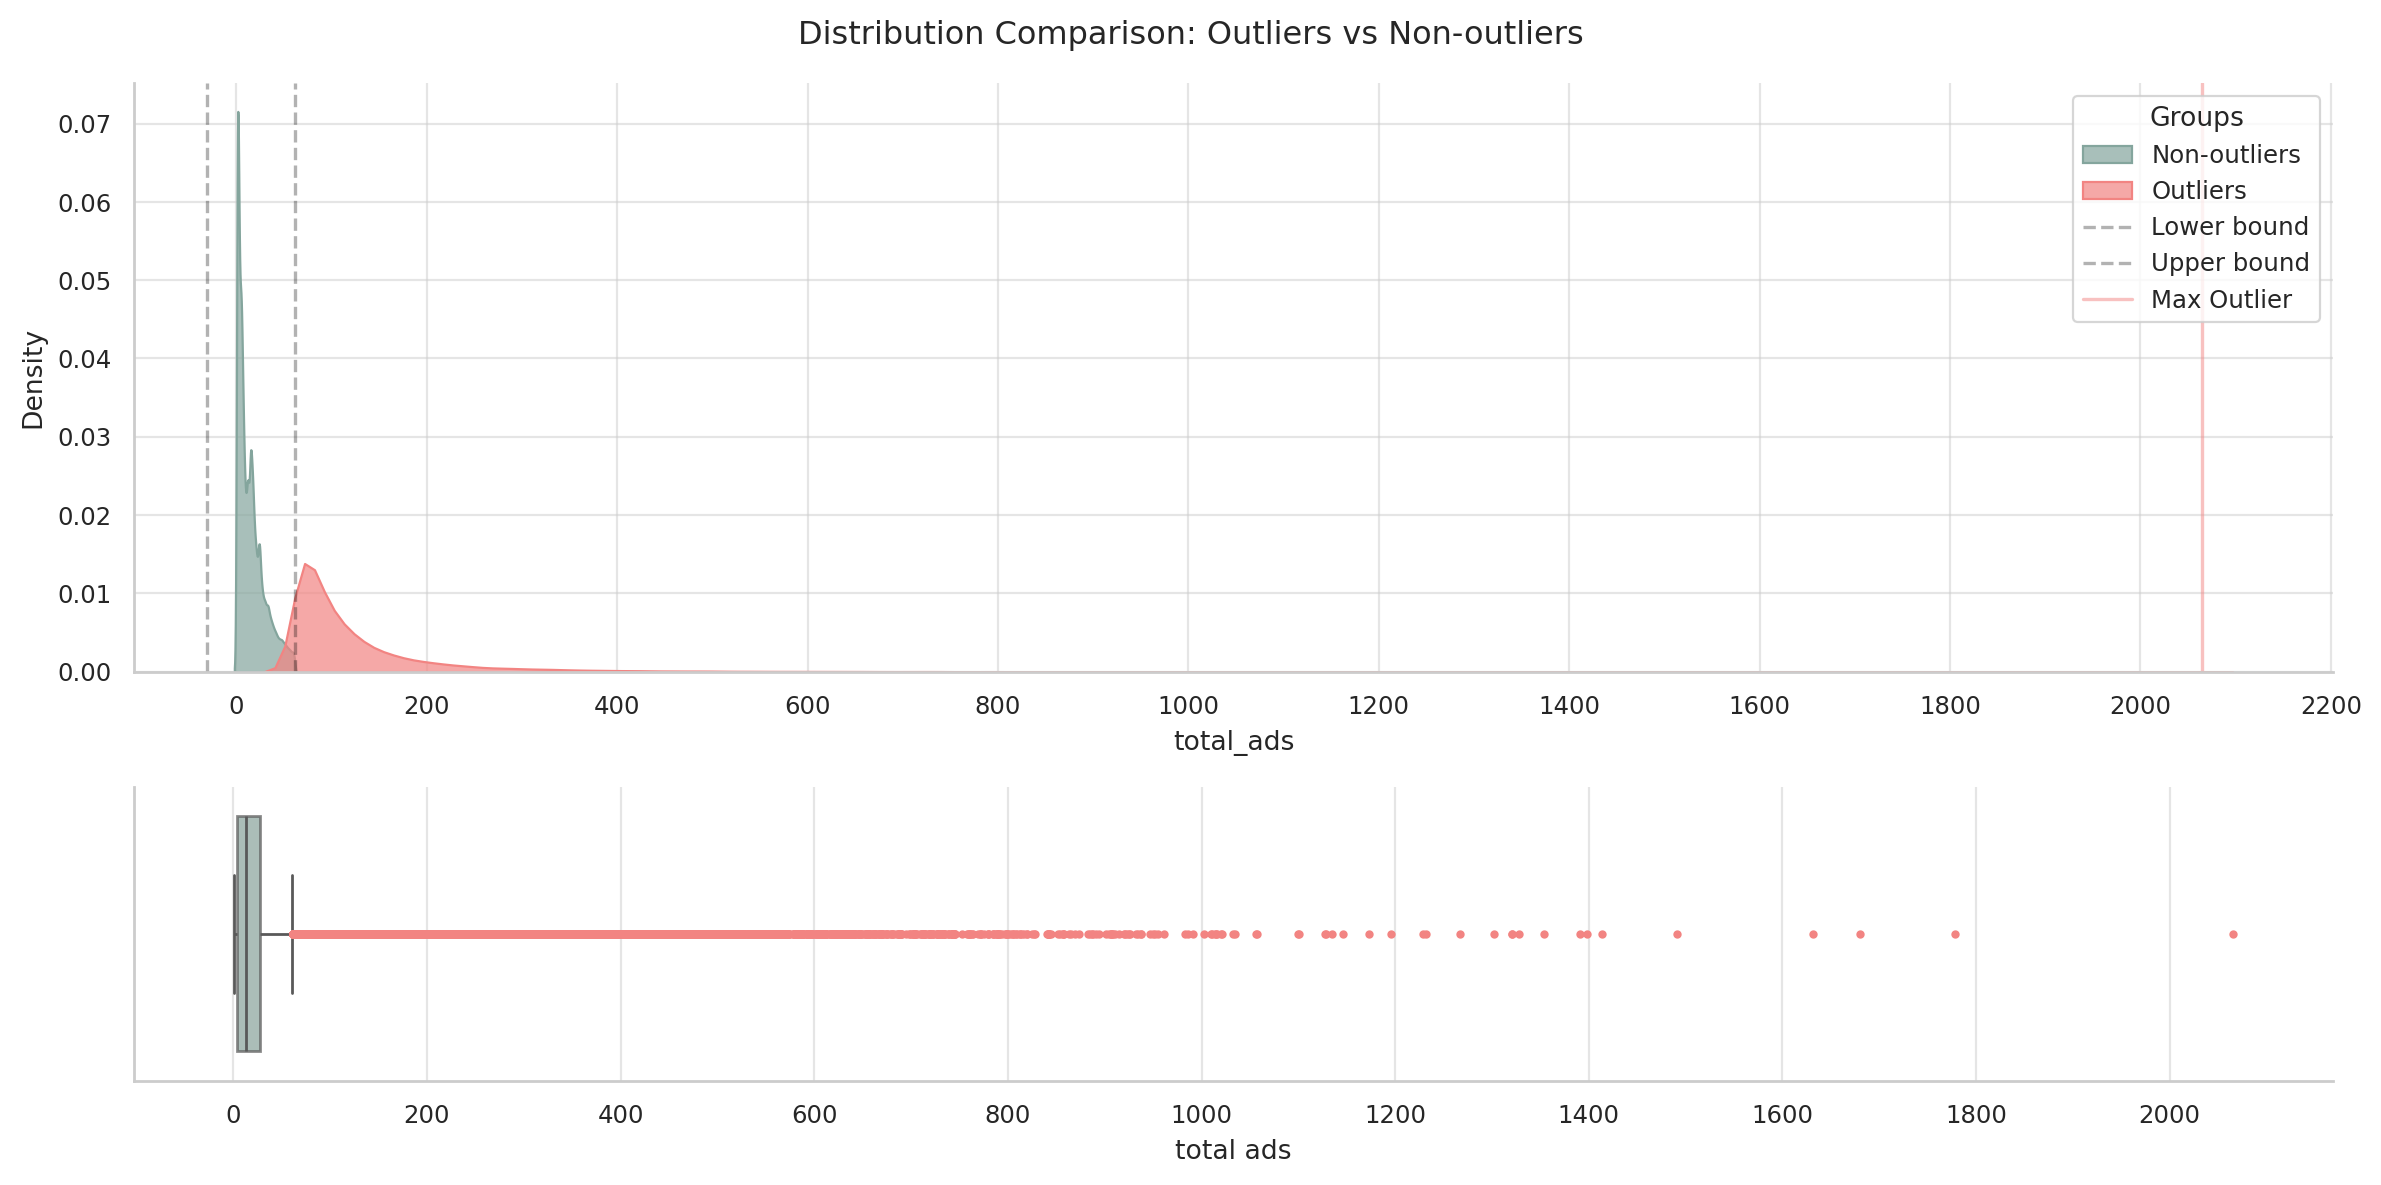

In [8]:
# Visualize the 'total_ads' distribution
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, height_ratios=[2, 1])

# First subplot: KDE plots for both outliers and non-outliers
sns.kdeplot( data=ad_campaign[~ad_campaign.index.isin(outliers.index)]['total ads'], label='Non-outliers',
    fill=True,
    alpha=0.7,
    color=custom_colors[3],
    ax=ax1
)

sns.kdeplot(data=outliers['total ads'], label='Outliers', fill=True, alpha=0.7,
    color=custom_colors[4],
    ax=ax1
)

# Add vertical lines for outlier boundaries in first subplot
ax1.axvline(x=down_limit, color='black', linestyle='--', alpha=0.3, label='Lower bound')
ax1.axvline(x=upper_limit, color='black', linestyle='--', alpha=0.3, label='Upper bound')
ax1.axvline(x=outliers['total ads'].max(), color=custom_colors[4], linestyle='-', alpha=0.5, label='Max Outlier')

# Customize first subplot
ax1.set_xlabel('total_ads')
ax1.set_ylabel('Density')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax1.legend(title='Groups', loc='upper right')

# Second subplot: Boxplot of 'total_ads' distribution
sns.boxplot(x=ad_campaign['total ads'], ax=ax2, color=custom_colors[3], boxprops=dict(alpha=.7),
           linewidth=1, flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': custom_colors[4],
           'markeredgecolor': custom_colors[4]})

ax2.set_xlabel('total ads')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(200))

# Add figure title
fig.suptitle('Distribution Comparison: Outliers vs Non-outliers')
# Adjust layout to prevent overlap
plt.tight_layout()
# Remove the top and right spines
[ax.spines[side].set_visible(False) for ax in [ax1, ax2] for side in ['top', 'right']]
plt.show()

In [9]:
# Create a filtered df without outliers
no_outliers_df = ad_campaign[~ad_campaign.index.isin(outliers.index)]

# Calculate avg seen ads with/without outliers
mean_ads_overall = ad_campaign['total ads'].mean()
mean_ads_no_outliers = no_outliers_df['total ads'].mean()
print(f'Avg. ads seen overall: {mean_ads_overall:.0f} ads')
print(f'Avg. ads seen without outliers: {mean_ads_no_outliers:.0f} ads')

Avg. ads seen overall: 25 ads
Avg. ads seen without outliers: 15 ads


In [10]:
# Calculate overall conversion rate
conversion_rate = (ad_campaign['converted'] == True).mean() * 100
print(f'Overal conversion rate (with outliers): {conversion_rate:.2f}%')

# Calculate conversion rate for the filtered dataset
no_outliers_conversion_rate = (no_outliers_df['converted'] == True).mean() * 100
print(f'Conversion rate without outliers: {no_outliers_conversion_rate:.2f}%')

# Calculate the relative difference in conversion rates
relative_diff = ((conversion_rate - no_outliers_conversion_rate) / conversion_rate) * 100
print(f"\nRelative difference in conversion rates: {relative_diff:.2f}%")

Overal conversion rate (with outliers): 2.52%
Conversion rate without outliers: 1.33%

Relative difference in conversion rates: 47.41%


The conversion rate drops by about 47% when removing outliers (from 2.52% to 1.33%).

In [11]:
# Check the origin of outliers
print('Outliers conversion distribution by test_group\n')
outliers_pivot = (outliers.groupby('test group')['converted']).value_counts(normalize=True).unstack() * 100
outliers_pivot

Outliers conversion distribution by test_group



converted,False,True
test group,,
ad,84.8900,15.1100
psa,91.1658,8.8342


Only 15% of those who saw an ad was converted (among outliers). It indicates that the enormous amount of ads seen by users weakly affects the conversion.

In [12]:
# Check the percent of converted users among outliers
outliers_conversion = outliers['converted'].value_counts(normalize=True).mul(100).round(2).reset_index()
print(f'Outliers Conversion Rate: {outliers_conversion.iloc[1,1]:.2f} %')

Outliers Conversion Rate: 14.85 %


**Preprocessing**

In [16]:
ad_campaign.head(1)

,Unnamed: 0,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,0,1069124,ad,False,130,Monday,20


In [17]:
ad_campaign.rename(columns={
    'user id': 'user_id',
    'test group': 'test_group',
    'total ads': 'total_ads',
    'most ads day': 'most_ads_day',
    'most ads hour': 'most_ads_hour'
}, inplace=True)

Converting Datatypes

In [18]:
# Convert 'converted' field to integer
ad_campaign['converted'] = ad_campaign['converted'].astype(int)

Removing Outliers

In [19]:
# df = df[~((df[col] < down_limit) | (df[col] > up_limit))]
ad_campaign_clean = ad_campaign[~((ad_campaign['total_ads'] < down_limit) | (ad_campaign['total_ads'] > upper_limit))]
ad_campaign_clean = ad_campaign_clean.reset_index(drop=True)
ad_campaign_clean.head()

,Unnamed: 0,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,2,1144181,ad,0,21,Tuesday,18
1,7,1496843,ad,0,17,Sunday,18
2,8,1448851,ad,0,21,Tuesday,19
3,11,1637531,ad,0,47,Wednesday,13
4,12,1081965,ad,0,61,Tuesday,20


CAMPAIGN EFFECTIVENESS

* Is there a statistically significant difference in conversion rates between ad and PSA groups?
* What is the confidence interval for difference in conversion rates if it exists?
* What is the effect size (how much better/worse did the ad group perform)?

Is there a statistically significant difference in conversion rates between Ad and PSA groups?

To address this question using a statistical hypothesis test, a 5% significance level.

The hypotheses are formulated as follows:

* Null Hypothesis (H₀): The conversion rate in the ad group equal to  the conversion rate in the PSA group (p_ad - p_psa = 0).
* Alternative Hypothesis (H₁): The conversion rate in the ad group is higher than in the PSA group (p_ad - p_psa > 0).

Plan:

* Choose appropriate test
* Check the assumptions of inference
* Change the testing method if the assumptions aren't not met
* Analyze the results

Two-proportion Z-test(parametric) is the best for such measuring the difference in proportions. It's a well known standard in conversion rate optimization (CRO).
If the assumptions will not be met - the non-parametric alternative is Chi-square Homogeneity(non-parametric).

Assumption for Two-proportion Z-test:

1. Normality (both samples are large enough: np ≥ 10 and n(1-p) ≥ 10 for both groups)
2. Independence (observations within and between groups independent)
3. Random sampling

In [20]:
# Create separate groups
treatment_group = ad_campaign_clean[ad_campaign_clean['test_group'] == 'ad']
control_group = ad_campaign_clean[ad_campaign_clean['test_group'] == 'psa']

In [21]:
# Calculate conversion rates in both groups (treatment and control)
treatment_conversion_rate = (treatment_group['converted'] == True).mean()
print(f'Treatment Group Conversion rate: {treatment_conversion_rate:.2%}')

control_conversion_rate = (control_group['converted'] == True).mean()
print(f'Control Group Conversion rate: {control_conversion_rate:.2%}')

# Calculate absolute difference abf relative lift in conversion
diff = treatment_conversion_rate - control_conversion_rate
print(f'\nAbsolute difference: {diff:.2%}')

rel_lift = ((treatment_conversion_rate - control_conversion_rate)/control_conversion_rate)
print(f'Relative Lift in conversion {rel_lift:.2%}')

Treatment Group Conversion rate: 1.34%
Control Group Conversion rate: 1.06%

Absolute difference: 0.28%
Relative Lift in conversion 26.31%


* Absolute difference: 0.28% higher conversion rate in the AD group
* On average, the ad group converts 26.3% better than the PSA group (should be considered alongside the low base conversion rate)

ASSUMPTIONS CHECK

In [22]:
def assump_check(control_group, treatment_group, target_col, user_id_col):
    # Normality
    n_control = len(control_group)
    p_control = control_group[target_col].mean()
    control_assumption = n_control * p_control * (1 - p_control)

    n_treatment = len(treatment_group)
    p_treatment = treatment_group[target_col].mean()
    treatment_assumption = n_treatment * p_treatment * (1 - p_treatment)

    # Independence
    # 1.Within groups duplicates
    duplicates_treatment = treatment_group[user_id_col].duplicated().sum()
    duplicates_control = control_group[user_id_col].duplicated().sum()

    # 2.Between groups duplicates (overlap)
    treatment_users = set(treatment_group[user_id_col])
    control_users = set(control_group[user_id_col])
    overlapping_users_num = len(treatment_users.intersection(control_users))

    # Calculate ratio for reporting group size difference
    ratio = n_treatment/n_control
    print(f'Treatment/Control ratio: {ratio:.2f}')

    # Check conditions for parametric test
    if (control_assumption >= 10 and treatment_assumption >= 10 and
        duplicates_treatment == 0 and duplicates_control == 0 and
        overlapping_users_num == 0):
        return 'The Assumption for Parametric were met. Conduct the Two-proportion Z-test.'
    else:
        return 'The Assumption for Parametric were NOT met. Conduct the Chi-square Homogeneity test.'

In [23]:
assump_check(control_group, treatment_group, 'converted', 'user_id')

Treatment/Control ratio: 24.13


'The Assumption for Parametric were met. Conduct the Two-proportion Z-test.'

Conducting a Two proportion Z test

In [24]:
# Data Preparation
# Count successes (conversions)
successes = [
    sum(treatment_group['converted'] == True),    # number of conversions in ad group
    sum(control_group['converted'] == True)    # number of conversions in psa group
]

# Get sample sizes
nobs = [
    len(treatment_group),    # total number in ad group
    len(control_group)    # total number in psa group
]

# Calculate proportions
p_ad = successes[0]/nobs[0]
p_psa = successes[1]/nobs[1]

# Conduct one-tailed Two-proportion Z-test
z_stat, p_value = proportions_ztest(count=successes,
                                 nobs=nobs,
                                 alternative='larger')

if p_value < 0.05:
    print("Reject the Null Hypothesis: The 'ad' group has a significantly higher conversion rate than the 'psa' group.\nThe ad campaign shows statistically significant improvement.")
else:
    print("Fail to reject the Null Hypothesis: There is no statistically significant evidence that the 'ad' group has a higher conversion rate than the 'psa' group.")

Reject the Null Hypothesis: The 'ad' group has a significantly higher conversion rate than the 'psa' group.
The ad campaign shows statistically significant improvement.


We can say with `95%` confidence that the 'ad' group has a significantly higher conversion rate than the 'psa' group.

Confidence Interval for Difference in Conversion Rate

In [25]:
# Calculate CI
ci = confint_proportions_2indep(
    count1=successes[0],  # successes in ad(treatment) group
    nobs1=nobs[0],        # total in ad group
    count2=successes[1],  # successes in psa(control) group
    nobs2=nobs[1],        # total in psa group
    alpha=0.05            # for 95% CI
)

print(f'95% CI for difference in proportions: ({ci[0]:.2%} - {ci[1]:.2%})')
print(f'\nCurrent Conversion Rate difference: {diff:.2%}')

95% CI for difference in proportions: (0.13% - 0.41%)

Current Conversion Rate difference: 0.28%


The `95%` confidence interval (0.13% - 0.41%) indicates consistent positive effect of th Ad Campaign.
We can expect between 0.13% and 0.41% higher conversion rate.
The curent difference (0.28%) in conversion we captured lies roughly in the middle of 95% CI.

POWER ANALYSIS

In [26]:
# Initialize the power analysis
power_analysis = NormalIndPower()

# Calculate effect size using Cohen's h
def cohen_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

# Calculate the effect size
effect_size = cohen_h(p_ad, p_psa)

# Calculate power
power = power_analysis.solve_power(
    effect_size=effect_size,
    nobs1=nobs[0],    # sample size of ad group
    alpha=0.05,       # significance level
    ratio=nobs[1]/nobs[0],  # ratio of sample sizes (psa/ad)
    alternative='larger'     # one-sided test
)

print(f'\nStatistical Power: {power:.4f}')


Statistical Power: 0.9786


The test achieved **high statistical power** (`0.9786` > `0.80`), indicating reliable detection of the observed effect if it exist.

**Business Interpretation of the Results**

A/B testing revealed that while the AD campaign achieved statistical significance with high power (0.9786) and a positive lift over PSAs, the absolute improvement in conversion rate was minimal (0.28%).
Though we observed a 26.3% relative improvement and can be 95% confident the true effect lies between 0.13% and 0.41%, the small absolute difference suggests limited practical impact despite statistical reliability.

**Recommendations**

Before scaling the AD campaign, a thorough cost-benefit analysis is recommended, with a potential search of alternative ad strategies.

RETURN ON INVESTMENT(ROI)

How much additional revenue can be expected from using ads vs PSAs?

To estimate revenue impact, we'll calculate additional revenue gained per 1000 user afted running an ad campaign. Assume the avg. revenue per conversion is $55.50.

In [27]:
# Assuming the average revenue per conversion
avg_revenue_per_conversion = 55.5

# Calculate additional revenue per 1000 users
base_revenue = 1000 * control_conversion_rate * avg_revenue_per_conversion
expected_revenue = 1000 * treatment_conversion_rate * avg_revenue_per_conversion

print(f'Base revenue per 1K users: ${base_revenue:.2f}')
print(f'Expected revenue per 1K users: ${expected_revenue:.2f}')

additional_revenue = expected_revenue - base_revenue
print(f'Additional revenue: ${additional_revenue:.2f}')


# Calculate an expected revenue increase interval using CIs
expected_revenue_low = 1000 * (ci[0] + control_conversion_rate) * avg_revenue_per_conversion
expected_revenue_up = 1000 * (ci[1] + control_conversion_rate) * avg_revenue_per_conversion

print(f'\nExpected revenue range per 1K users: ${expected_revenue_low:.2f} - ${expected_revenue_up:.2f}')

Base revenue per 1K users: $588.10
Expected revenue per 1K users: $742.82
Additional revenue: $154.72

Expected revenue range per 1K users: $659.71 - $816.48


Based on the A/B testing analysis, implementing the ad campaign generates an additional revenue around 155.0 Dollors per 1,000 users compared to showing PSAs. With an assumed revenue per conversion of $50.50, this represents measurable financial improvement over the baseline PSA performance. While the absolute revenue increase appears modest due to low conversion rates, the relative lift indicates positive campaign effectiveness.

**Recommendations**

Further optimization of ad delivery timing and targeting could potentially enhance the returns.

AD Exposure Impact

* Is there a correlation between the number of ads seen and conversion rate?
* What is the optimal number of ad exposures for conversion?

Ads Exposure and Conversion Rate correlation

Is there a correlation between the number of ads seen and conversion rate?

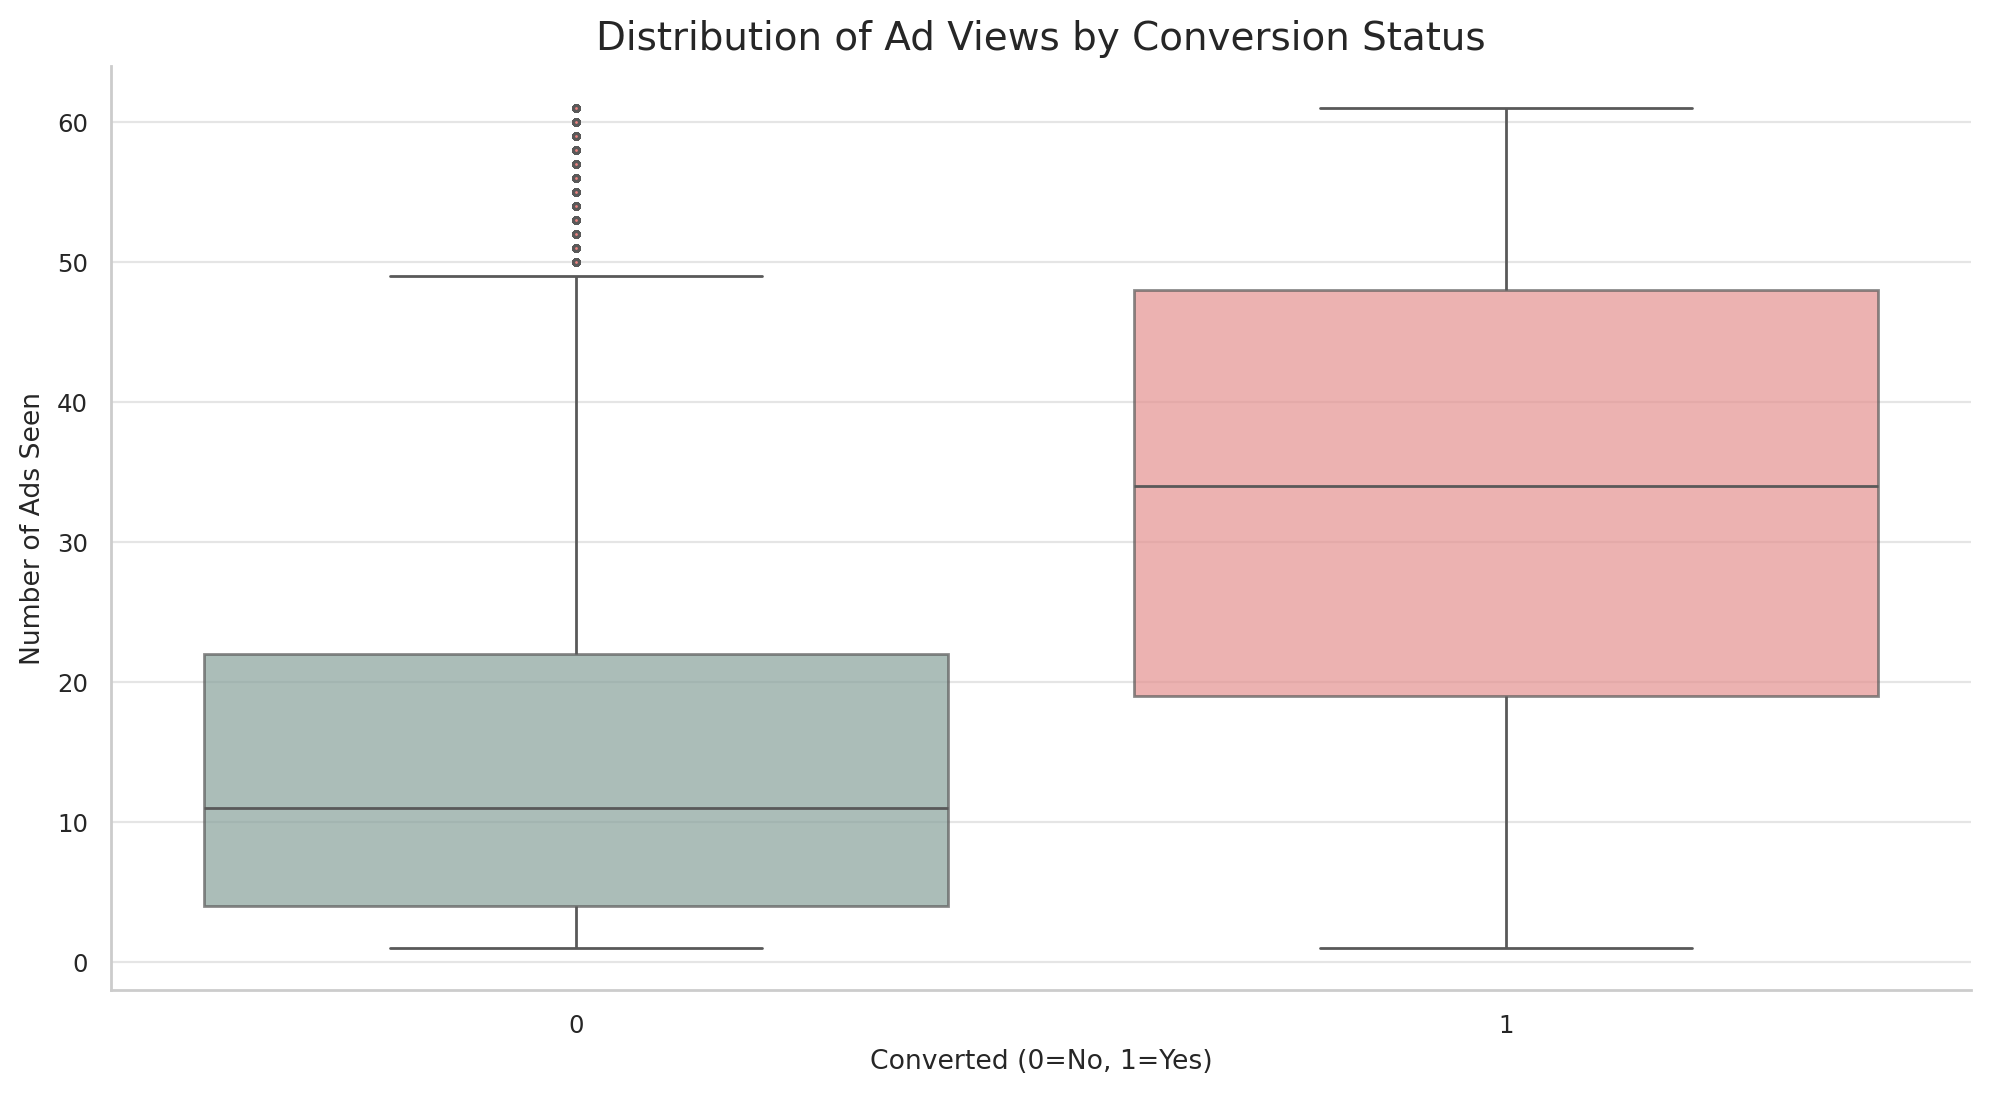

In [28]:
# Create a box plot to visualize distribution of ads for converted vs non-converted
fig, ax = plt.subplots()

sns.boxplot(
    data=ad_campaign_clean,
    x='converted',
    y='total_ads',
    palette=custom_colors[3:],
    boxprops=dict(alpha=0.7),
    linewidth=1,
    flierprops={
        'marker': 'o',
        'markersize': 2,
        'markerfacecolor': custom_colors[4]  # Color for the outliers
    }
)
plt.title('Distribution of Ad Views by Conversion Status')
plt.xlabel('Converted (0=No, 1=Yes)')
plt.ylabel('Number of Ads Seen')

# Remove the top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

Users who converted (1) demonstrate notably higher median ad views and a broader IQR compared to non-converters (0), suggesting that increased ad exposure may influence conversion probability.

Point-biserial is specifically designed for correlating:

* One continuous variable (total_ads)
* One dichotomous/binary variable (converted: 0/1)

It's mathematically equivalent to Pearson correlation but more appropriate interpretation for binary variables.

In [29]:
# Create a function to calculate the Point-biserial correlations coeffcient
def interpret_correlation(col_1, col_2, alpha=0.05):
    pointbi_corr, pointbi_p = stats.pointbiserialr(col_1, col_2)

    # Check statistical significance
    if p_value > alpha:
        return 'No significant correlation found (p > 0.05)'

    # Interpret strength
    if abs(pointbi_corr) < 0.1:
        strength = 'negligible'
    elif abs(pointbi_corr) < 0.3:
        strength = 'weak'
    elif abs(pointbi_corr) < 0.5:
        strength = 'moderate'
    elif abs(pointbi_corr) < 0.7:
        strength = 'strong'
    else:
        strength = 'very strong'

    direction = 'positive' if pointbi_corr > 0 else 'negative'
    return print(f'Significant {strength} {direction} correlation is detected: r = {pointbi_corr:.2f}, p < {alpha})')

In [30]:
# Use the function
result = interpret_correlation(ad_campaign_clean['total_ads'], ad_campaign_clean['converted'])

Significant weak positive correlation is detected: r = 0.15, p < 0.05)


# Optimal number of Ad exposures
What is the optimal number of ad exposures for conversion?

In [31]:
# Make sure to run the cell that defines ad_campaign_clean first

# use only treatment (ad) group for temporal analysis since we're optimizing ad performance
ad_data = ad_campaign_clean[ad_campaign_clean['test_group'] == 'ad']
ad_data.head()

,Unnamed: 0,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,2,1144181,ad,0,21,Tuesday,18
1,7,1496843,ad,0,17,Sunday,18
2,8,1448851,ad,0,21,Tuesday,19
3,11,1637531,ad,0,47,Wednesday,13
4,12,1081965,ad,0,61,Tuesday,20


In [32]:
ad_data_exp = ad_data.copy()
# Divide ad exposures into 10 equal-sized groups for analysis
ad_data_exp['exposure_bins'] = pd.qcut(ad_data_exp['total_ads'], q=10, duplicates='drop', precision=0)

Calculate key metrics for each exposure bin
Will be used for further plotting.

In [33]:
# Calculate conversion metrics for each exposure level
conversion_by_exposure = ad_data_exp.groupby('exposure_bins', observed=False).agg({
    'converted': ['count', 'mean', 'sum'],  # Get total users, conversion rate, total conversions
    'total_ads': 'mean'                     # Average number of ads shown in this bin
}).reset_index()

conversion_by_exposure.head(3)

exposure_bins converted             total_ads
                    count   mean  sum      mean
0    (0.0, 3.0]    119537 0.0021  254    1.7744
1    (3.0, 5.0]     50425 0.0034  173    4.5558
2    (5.0, 7.0]     40681 0.0040  164    6.4502

In [34]:
# Fit logistic regression to model probability of conversion based on ad exposures
model = logit('converted ~ total_ads', data=ad_data_exp).fit()

# Print the parameters of the fitted model
print(model.params)
print(f'\nIntercept: {model.params.iloc[0]:.4f}\nSlope: {model.params.iloc[1]:.4f}')

Optimization terminated successfully.
         Current function value: 0.062669
         Iterations 9
Intercept   -5.7875
total_ads    0.0640
dtype: float64

Intercept: -5.7875
Slope: 0.0640


Check Model Accuracy

In [35]:
# Generate predictions for model evaluation
ad_data_exp['predicted_prob'] = model.predict(ad_data_exp)

# Calculate model accuracy (AUC score): 0.5=random, 1.0=perfect
auc_score = roc_auc_score(ad_data_exp['converted'], ad_data_exp['predicted_prob'])

# Define performance levels
auc_levels = {
   0.9: "Excellent",
   0.8: "Very good",
   0.7: "Good",
   0.6: "Fair",
   0.5: "Poor"
}

# Find appropriate performance level
performance = next((v for k, v in auc_levels.items() if auc_score >= k), "Worse than random")

print(f"AUC: {auc_score:.3f} - {performance} model performance")

AUC: 0.797 - Good model performance


Create the function for finding the optimal number of ads to post
The marginal_return formula is the derivative of the logistic function. It tells us how fast probability is growing at each point (each number of ads). In simple words, it calculates the slope of the logistic curver at each x point.

In [37]:
def find_optimal_ad_exposures(df, model):
    """
    Calculate optimal number of ad exposures by finding point of diminishing returns.

    Parameters:
        df: pd.DataFrame containing ad exposure data
        model: Fitted logistic regression model with intercept and slope parameters

    Returns:
        int: Optimal number of ad exposures where marginal returns start diminishing

    Formula:
        Marginal Return = slope * e^(intercept + slope*x) / (1 + e^(intercept + slope*x))^2,

        where x is number of ad exposures
    """
    # Calculates how much one additional ad increases conversion probability
    # (finds slope at each point of the S-shaped logistic curve)
    def marginal_return(x, beta0, beta1):
        return beta1 * np.exp(beta0 + beta1 * x) / (1 + np.exp(beta0 + beta1 * x))**2

    # minimize() function: starts at mean ads -> tries different values(x) -> follows decreasing marginal returns
    # -> stops at optimal point where adding more ads gives minimal benefit
    optimal_exposure = minimize(
        lambda x: -marginal_return(x, model.params.iloc[0], model.params.iloc[1]), # (-) turns minimization into maximization
        x0=df['total_ads'].mean(),
        bounds=[(df['total_ads'].min(), df['total_ads'].max())]
    ).x[0] # extract the only value

    return int(optimal_exposure)

# Apply the function
optimal_exposure = find_optimal_ad_exposures(ad_data_exp, model)
print(f'The optimal number of ads: {optimal_exposure}')

The optimal number of ads: 15


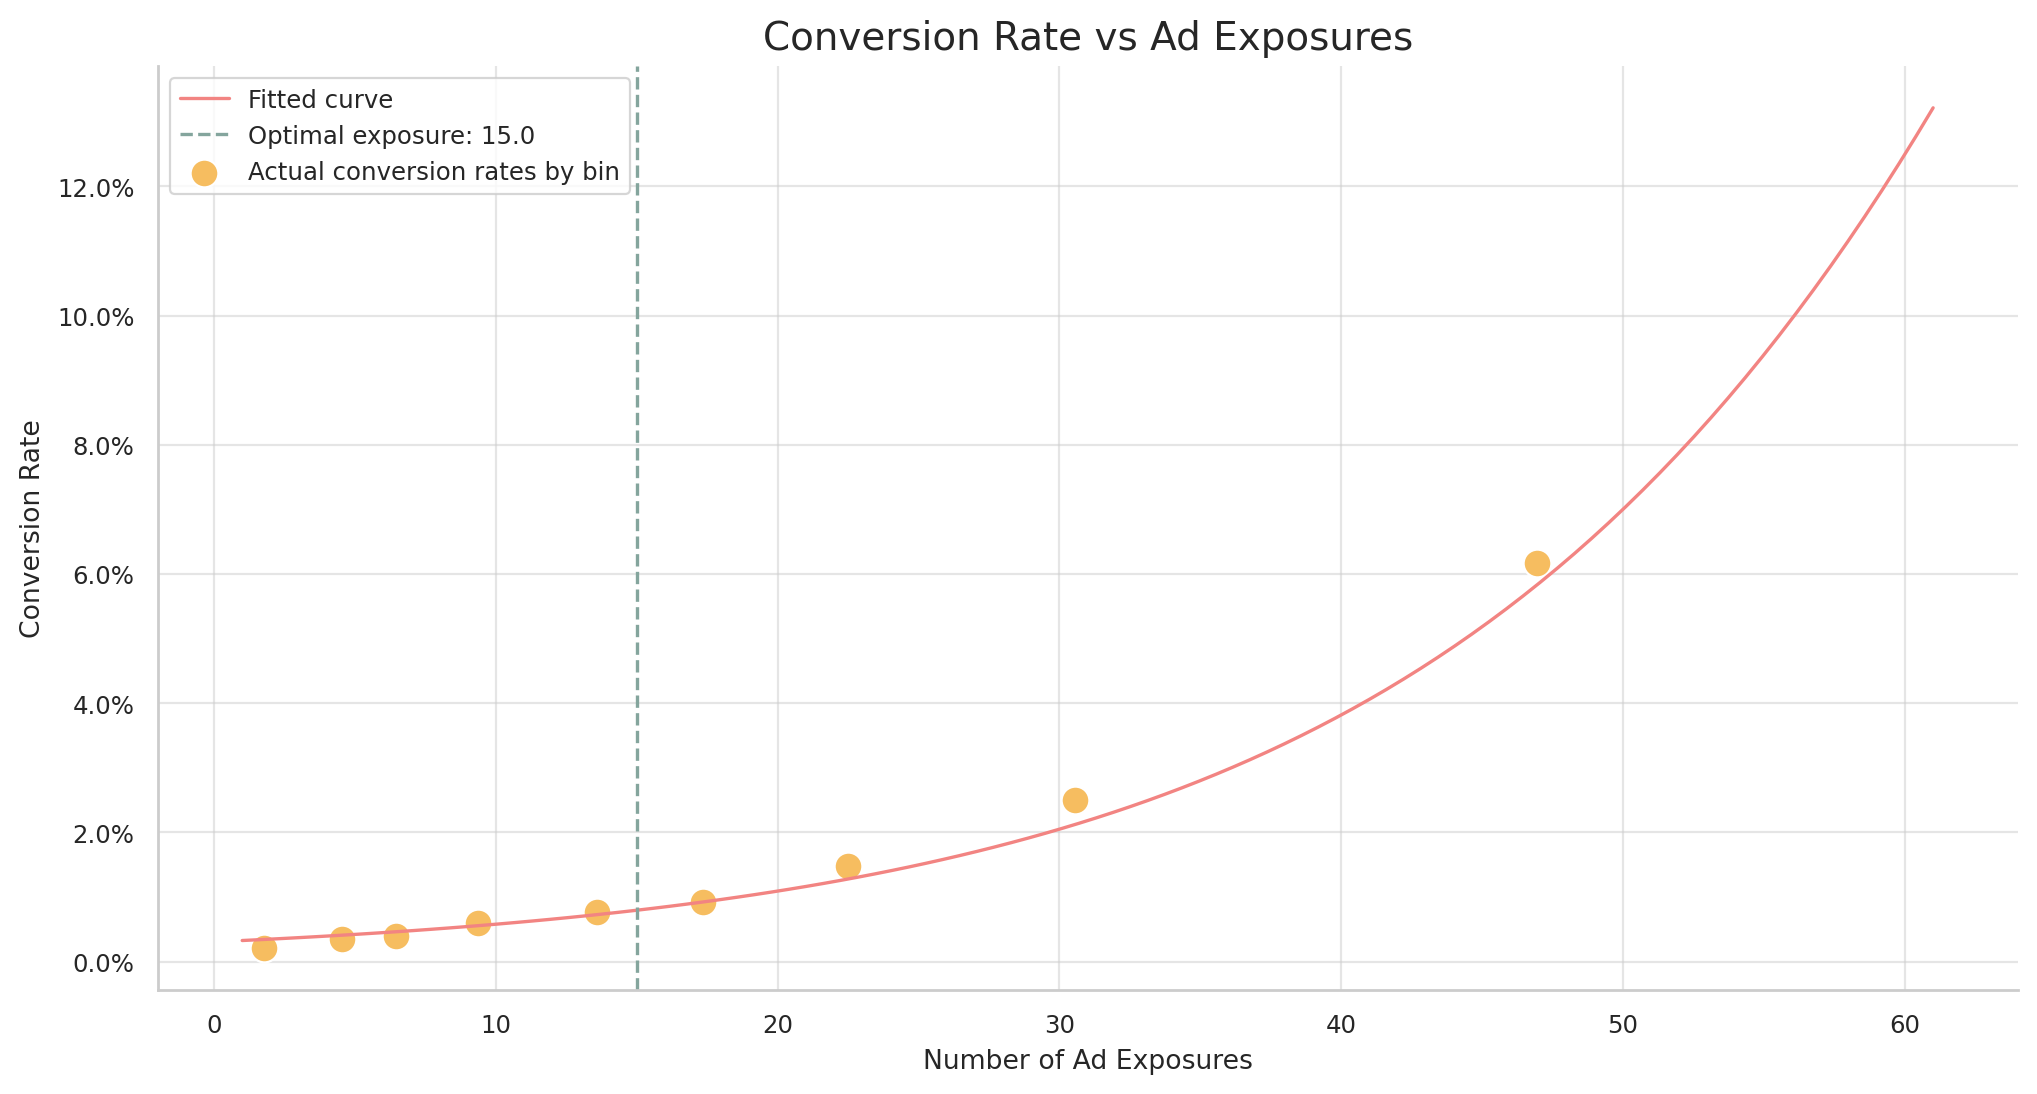

In [38]:
# Create visualization
fig, ax = plt.subplots()

x_range = np.linspace(ad_data_exp['total_ads'].min(), ad_data_exp['total_ads'].max(), 100)
y_pred = model.predict(pd.DataFrame({'total_ads': x_range}))

# Plot model's predicted conversion curve
sns.lineplot(x=x_range, y=y_pred, label='Fitted curve', color='#F28482')

# Mark optimal exposure point
ax.axvline(x=optimal_exposure, color='#84A59D', linestyle='--', label=f'Optimal exposure: {optimal_exposure:.1f}')

# Plot actual conversion rates by total_ads bin
sns.scatterplot(data=conversion_by_exposure,
               x=('total_ads', 'mean'), # MultiIndex column: ('total_ads', 'mean')
               y=('converted', 'mean'), # MultiIndex column: ('converted', 'mean')
               s=100,
               label='Actual conversion rates by bin')
# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

plt.title('Conversion Rate vs Ad Exposures')
plt.xlabel('Number of Ad Exposures')
plt.ylabel('Conversion Rate')
# Remove the top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend()
plt.show()

**Business Interpretation of the Results**

While more Ad views are somewhat associated with higher conversion, the relationship is weak (0.15). Other factors likely play a more important role in conversion. Simply increasing Ad views may not be the most effective strategy for improving conversion rates.

The optimal number of ad exposures is 15, after which:

* Marginal returns start diminishing significantly
* Each additional ad exposure provides less incremental benefit
* Even though conversion rates continue to rise up to 60 exposures, the efficiency of ad spend decreases

**Recommendations**

Target 15 ad exposures per user for optimal cost-effectiveness. It is better to focus on improving ad quality and targeting rather than just increasing frequency.

# Temporal Analysis

In essence, since the goal is to find the best times for showing ads, analyzing data from users who didn't see ads (PSA group) would introduce noise and potentially lead to incorrect conclusions about optimal ad timing. Treatment group (ad data) must be used exclusively for temporal analysis because:

* Purpose is to optimize ad campaign timing specifically
* Including PSA (control) data would dilute patterns specific to ad effectiveness
* Mixing treatment and control data could mask true temporal patterns of ad performance

We'll use only treatment (ad) group for temporal analysis since we're optimizing ad performance.

**Weekday Difference**

* Which days of the week show the highest conversion rates?
* Is the a significant difference in conversion between weekdays?
* What are the most effective day of week for ad display?

Which days of the week show the highest conversion rates?

In [39]:
# Calculate avg daily conversion for each weekday
daily_conv = ad_data.groupby('most_ads_day').agg({'converted': 'mean'}).round(3).reset_index()

# Calculate mean of daily conversion rates (avg across weekdays)
daily_avg_conversion = daily_conv['converted'].mean()

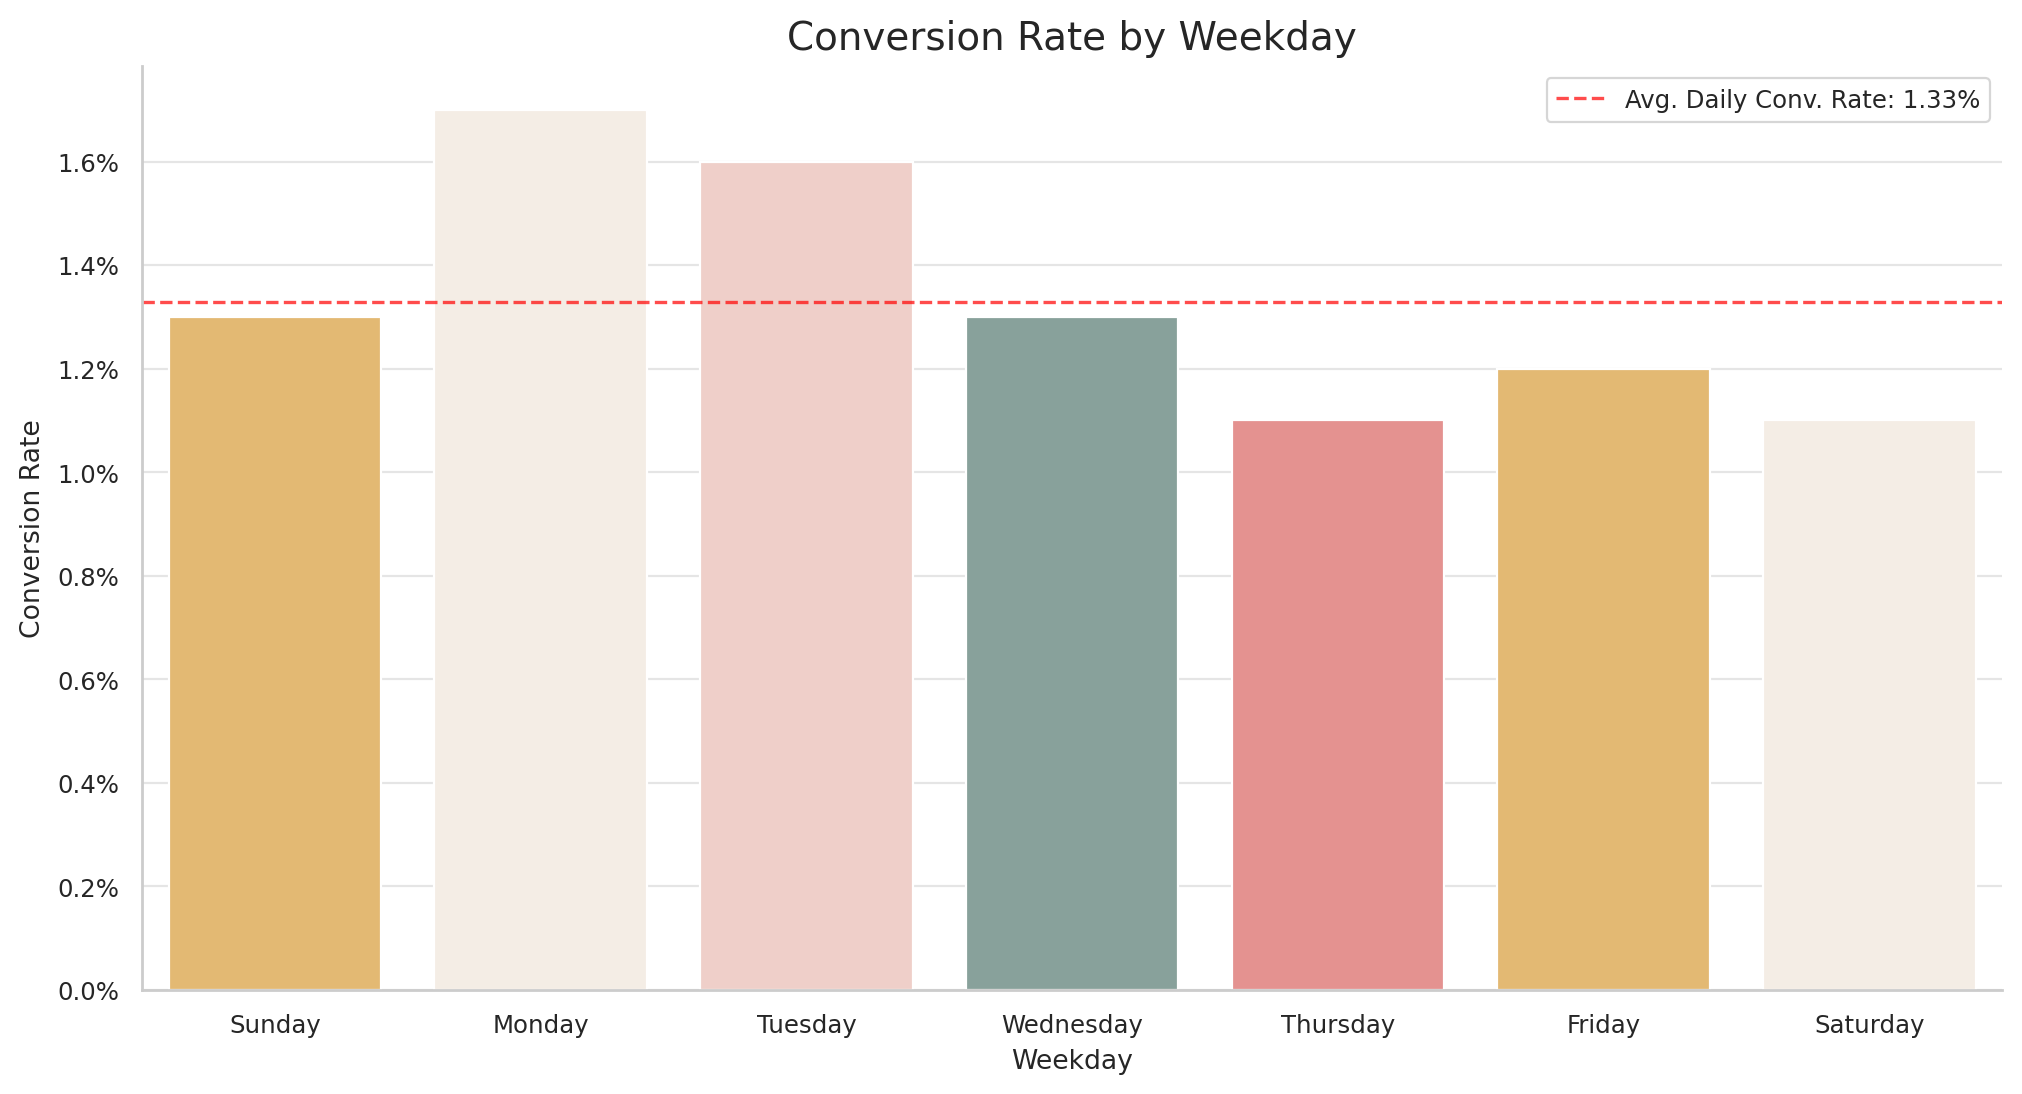

In [40]:
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']


# Create the figure
fig, ax = plt.subplots()

sns.barplot(data=daily_conv, x='most_ads_day', y='converted', order=day_order, palette=custom_colors, ax=ax)

# Add reference line for average conversion rate
ax.axhline(y=daily_avg_conversion, linestyle='--', alpha=0.7, color='red', label=f'Avg. Daily Conv. Rate: {daily_avg_conversion:.2%}')

# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

plt.title('Conversion Rate by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Conversion Rate')

plt.legend()
# Remove the top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

**Is the a significant difference in conversion between weekdays?**

Chi-square test of independence is optimal for analyzing conversion rate differences across weekdays because it specifically handles:

* Categorical variables (weekdays and binary conversion outcome)
* Binary/proportional data (converted/not converted), unlike ANOVA * which requires continuous dependent variables
* Large sample comparisons across multiple groups simultaneously

ANOVA is inappropriate here because:

* Conversion data is binary (0/1), not continuous
* ANOVA assumes normal distribution, which binary data violates
* ANOVA compares means of continuous variables, not proportions

In [41]:
# Create contingency table for the further testing
contingency = pd.crosstab(ad_data['most_ads_day'], ad_data['converted'])

# Conduct the Chi-square test
chi2_stat, p_value, _, _ = chi2_contingency(contingency)
print(f'Chi-square statistic: {chi2_stat:.4f}')
print(f'p-value: {p_value:.4f}')

if p_value < 0.05:
    print('\nReject the null hypothesis: There is a statistically significant difference in conversion rates across weekdays.')
else:
    print('\nFail to reject the null hypothesis: There is no statistically significant evidence of differences in conversion rates across weekdays.')

Chi-square statistic: 197.4258
p-value: 0.0000

Reject the null hypothesis: There is a statistically significant difference in conversion rates across weekdays.


**Baseline Comparison**

Statistical analysis aims to determine optimal weekdays for launching ad campaign by comparing daily conversion rates against the choosen baseline (average conversion across treatment group weekdays). This approach identifies days with significantly higher performance than typical results.

In [42]:
# Compare each day against baseline(avg. across weekdays)
results = []
for day in ad_data['most_ads_day'].unique():
    day_data = ad_data[ad_data['most_ads_day'] == day]

    # Z-test against baseline
    stat, p_val = proportions_ztest(
        [day_data['converted'].sum()],
        [len(day_data)],
        value=daily_avg_conversion,
        alternative='larger'  # test for higher conversion
    )

    # Calculate the conversion lift
    lift = (day_data['converted'].mean() - daily_avg_conversion) / daily_avg_conversion * 100
    # Append list of values to the 'result' list
    results.append([day, day_data['converted'].mean(), lift, p_val])

# Create df from list of lists
results_df = pd.DataFrame(results, columns=['Day', 'Conv Rate', 'Lift %', 'P-value'])
print(results_df.sort_values('Conv Rate', ascending=False))

         Day  Conv Rate   Lift %                   P-value
6     Monday     0.0174  31.3388   [9.847886411195401e-19]
0    Tuesday     0.0159  19.6495  [2.5116378444794103e-08]
2  Wednesday     0.0131  -1.2770      [0.6538722887079398]
1     Sunday     0.0131  -1.3173      [0.6635407229963548]
3     Friday     0.0119 -10.0601      [0.9997520032324506]
5   Thursday     0.0115 -13.6873      [0.9999979752693205]
4   Saturday     0.0108 -18.6911      [0.9999999999413033]


According to the analysis, weekday performance is strongest **early in the week (Mon-Tue).**

**What are the most effective day of week for ad display?**

*Post-hoc pairwise comparison*

After detection of significant conversion rate differences across weekdays via Chi-square test (p < 0.05), pairwise comparisons between all days may reveal specific performance variations.

**Z-test for proportions** is chosen for pairwise comparisons because:

* Directly compares conversion rates (proportions) between two groups
* Appropriate for binary outcomes (converted/not converted)
* Suitable for large sample sizes, meeting Central Limit Theorem requirements
* Tests whether the difference in proportions is statistically significant (Bonferroni correction accounts for multiple testing, maintaining statistical validity by controlling Type I error rate at 5% across all comparisons.)

In [44]:
# Get unique days
days = ad_data['most_ads_day'].unique()

# Initialize an empty list to store the pairwise test results
results = []

# Iterate over all unique pairwise combinations of days
for day1, day2 in combinations(days, 2): # generating all pairwise combinations
    day1_data = ad_data[ad_data['most_ads_day'] == day1]['converted']
    day2_data = ad_data[ad_data['most_ads_day'] == day2]['converted']

    # Perform a two-sided z-test for the difference in conversion proportions
    stat, pval = proportions_ztest(
        count=[day1_data.sum(), day2_data.sum()], # number of convertions for each day
        nobs=[len(day1_data), len(day2_data)],    # number of users for each day
        alternative='two-sided'                   # test for any difference (not directional)
    )
    # Append results to the list, formatting values to 4 decimal places
    results.append([
        day1, day2,
        f"{day1_data.mean():.4f}",
        f"{day2_data.mean():.4f}",
        f"{pval:.4f}"
    ])

    # Create DataFrame and apply Bonferroni correction to the p-value
pairwise_df = pd.DataFrame(results, columns=['Day1', 'Day2', 'Conv1', 'Conv2', 'P-value'])
pairwise_df['Adjusted P-value'] = multipletests([float(p) for p in pairwise_df['P-value']], method='bonferroni')[1] # Extract adjusted p-values

# Change the way adj. p-values are displayed
pairwise_df['Adjusted P-value'] = pairwise_df['Adjusted P-value'].apply(lambda x: f"{x:.4f}")

# Show only significant differences (adjusted p-value < 0.05)
significant_pairs = pairwise_df[pairwise_df['Adjusted P-value'].astype(float) < 0.05].sort_values('Adjusted P-value')
print(significant_pairs)

         Day1       Day2   Conv1   Conv2 P-value Adjusted P-value
0     Tuesday     Sunday  0.0159  0.0131  0.0000           0.0000
1     Tuesday  Wednesday  0.0159  0.0131  0.0000           0.0000
2     Tuesday     Friday  0.0159  0.0119  0.0000           0.0000
3     Tuesday   Saturday  0.0159  0.0108  0.0000           0.0000
4     Tuesday   Thursday  0.0159  0.0115  0.0000           0.0000
8      Sunday   Saturday  0.0131  0.0108  0.0000           0.0000
10     Sunday     Monday  0.0131  0.0174  0.0000           0.0000
14  Wednesday     Monday  0.0131  0.0174  0.0000           0.0000
17     Friday     Monday  0.0119  0.0174  0.0000           0.0000
19   Saturday     Monday  0.0108  0.0174  0.0000           0.0000
20   Thursday     Monday  0.0115  0.0174  0.0000           0.0000
12  Wednesday   Saturday  0.0131  0.0108  0.0001           0.0021


**Business Interpretation of the Results**

Based on pairwise conversion rate comparisons with Bonferroni correction (α=0.05), **Monday and Tuesday** emerge as optimal days for ad campaign launches. Monday demonstrates the highest conversion rate (1.74%), followed closely by Tuesday (1.59%), with no statistically significant difference between these two days (p=0.4557). Both days consistently outperform other weekdays by a significant margin.

Mid-week performance shows **Sunday and Wednesday** achieving moderate conversion rates (1.31%), significantly higher than weekend rates but lower than Monday/Tuesday performance. Thursday, Friday, and Saturday shows the lowest conversion rates.

**Recommendations**

Concentrate ad campaign resources on **Monday and Tuesday** to maximize conversion potential, with possible extension to **Sunday/Wednesday** if additional campaign days are required.

# Hour Difference
* Is there a significant difference in ad performance throughout the day?
* What are the most effective hours for ad display?

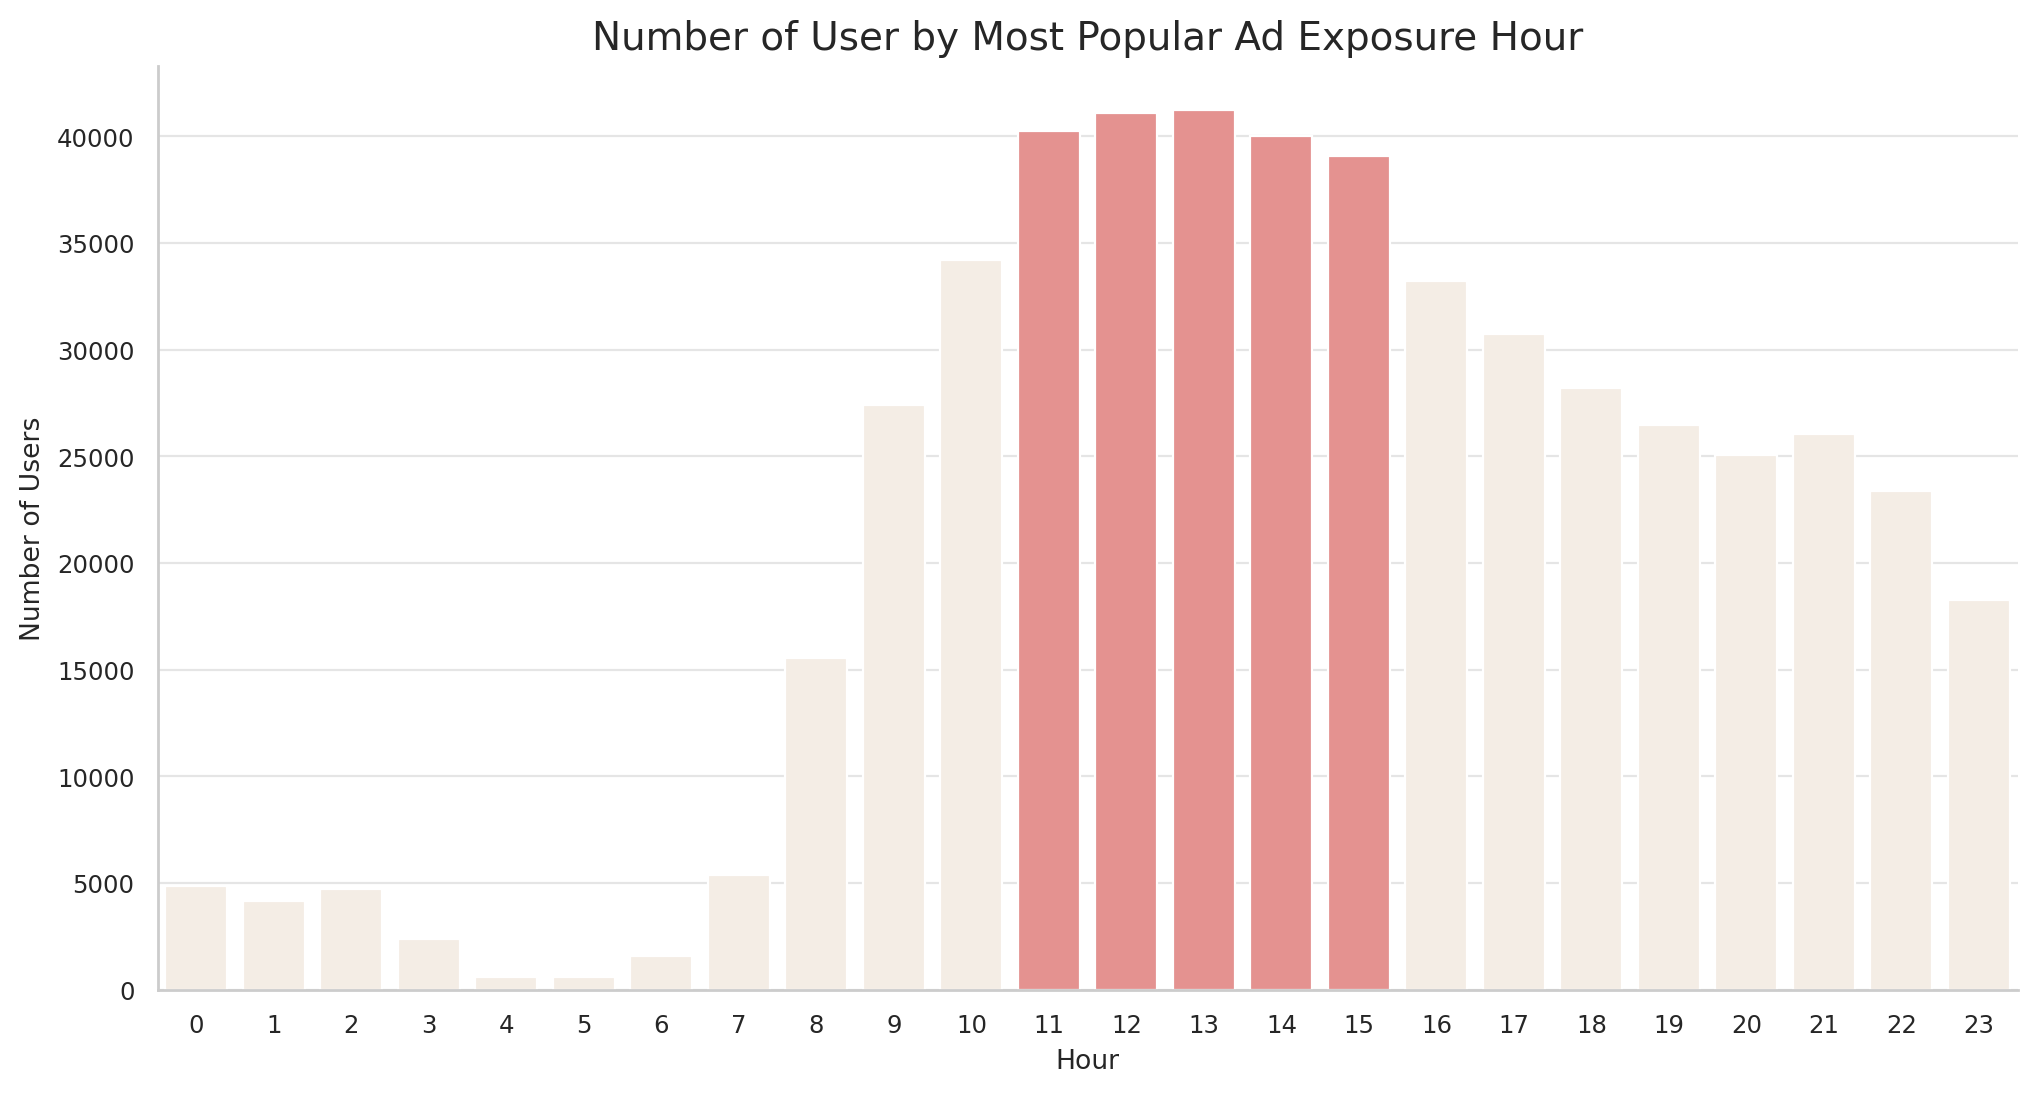

In [45]:
# Create the figure
fig, ax = plt.subplots()

# Get top 5 hours
top_5_hour_seen = ad_data['most_ads_hour'].value_counts().head(5).index.tolist()
colors = [custom_colors[4] if hour in top_5_hour_seen else custom_colors[1] for hour in sorted(ad_data['most_ads_hour'].unique())]

sns.countplot(data=ad_data, x='most_ads_hour', palette=colors, ax=ax)

plt.title('Number of User by Most Popular Ad Exposure Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Users')

# Remove the top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

**Current Ad Exposure Pattern:**

* Peak ad viewing occurs during midday 11AM-15PM with 40,000+ users per hour
* Ad exposure gradually decreases in late afternoon and evening hours
* Early morning hours 0AM-6AM show minimal ad activity

In [46]:
# Calculate avg conversion for each hour
hourly_conv = ad_data.groupby('most_ads_hour').agg({'converted': 'mean'}).round(3).reset_index()

# Calculate mean of daily conversion rates (avg across weekdays)
hourly_avg_conversion = hourly_conv['converted'].mean()

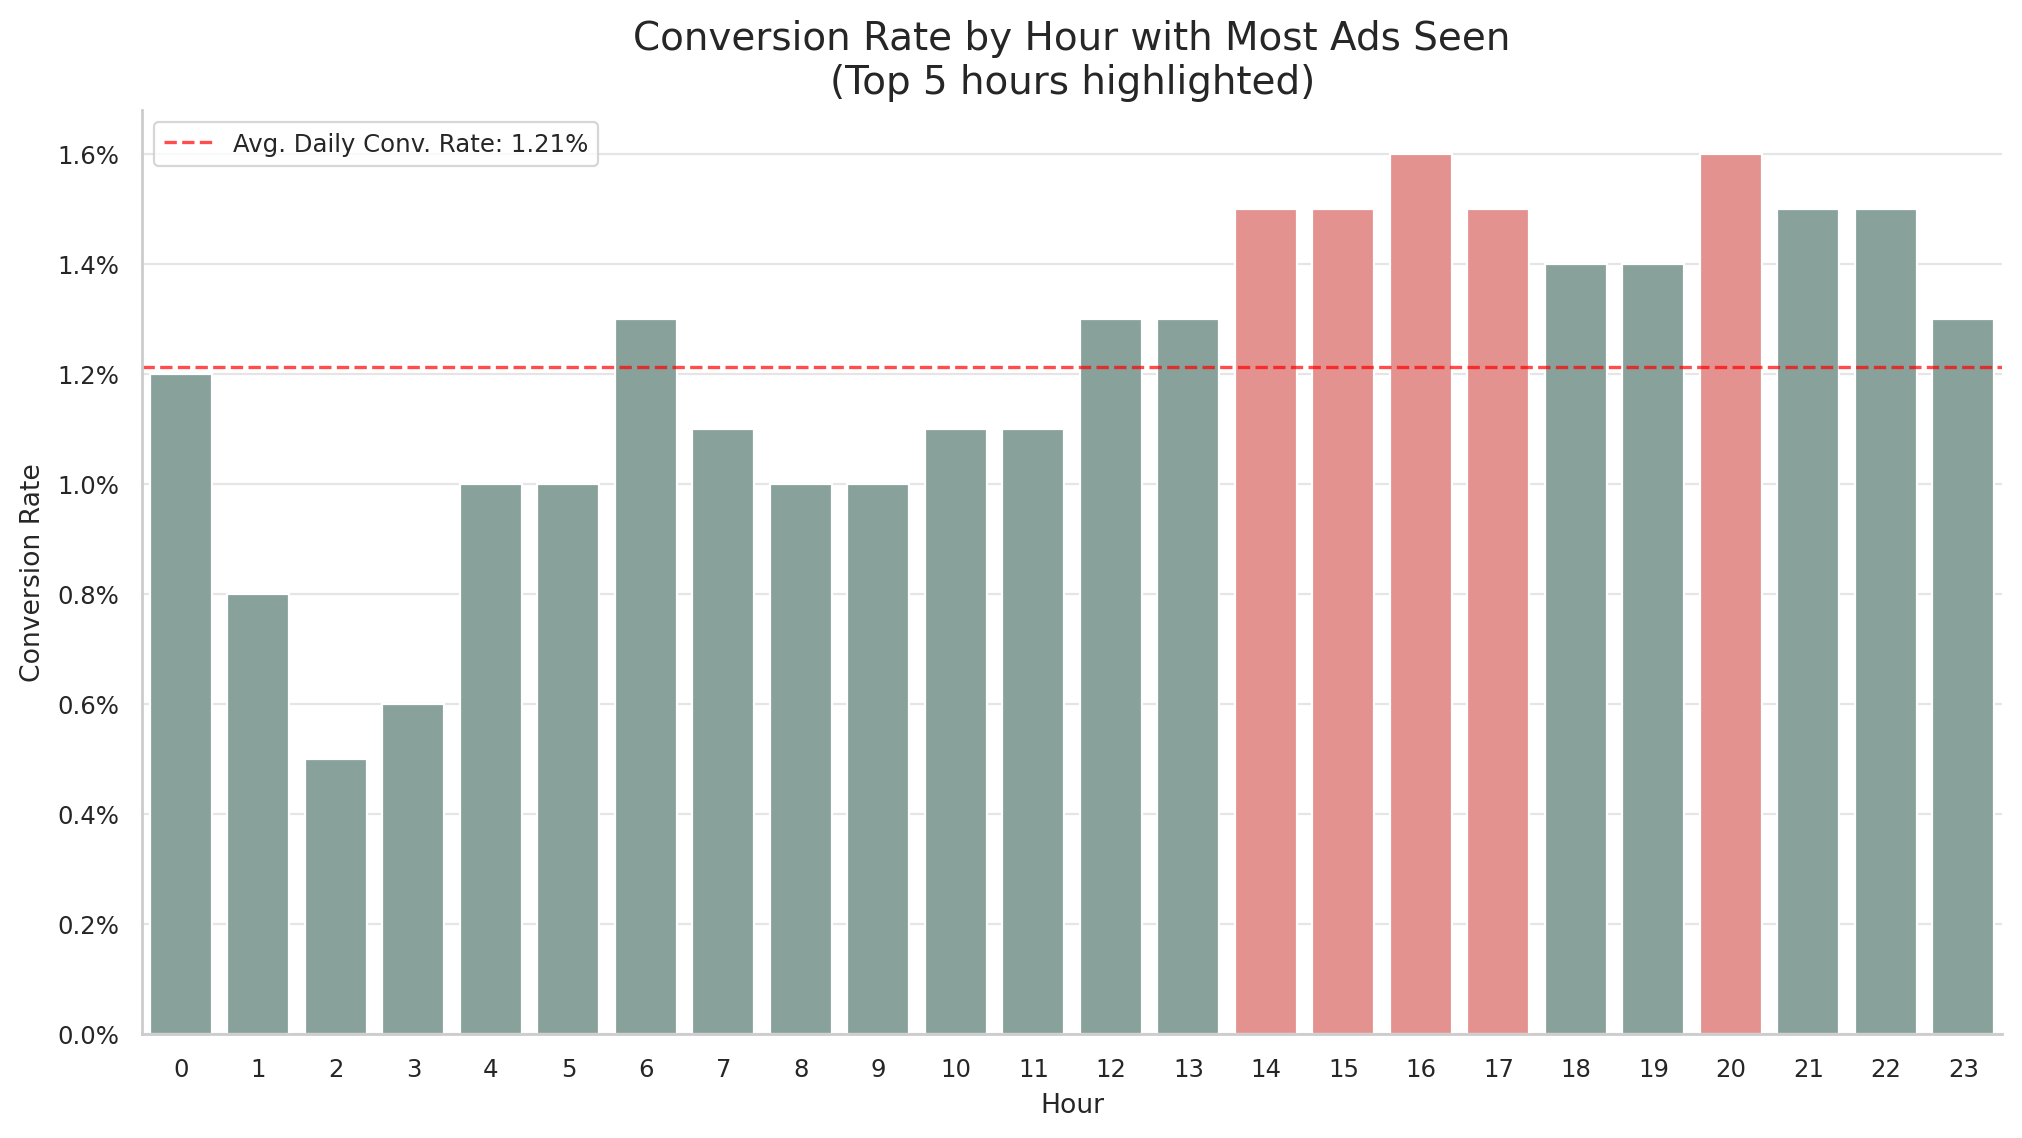

In [47]:
# Create figure
fig, ax = plt.subplots()

# Get top 5 hours
top_5_hours = hourly_conv.nlargest(5, 'converted')['most_ads_hour']

# Create bar plot with custom colors
colors = [custom_colors[4] if x in top_5_hours.values else custom_colors[3] for x in hourly_conv['most_ads_hour']]

sns.barplot(data=hourly_conv, x='most_ads_hour', y='converted', palette=colors, errorbar=('ci', 95), ax=ax)

# Add average line and formatting
ax.axhline(y=hourly_avg_conversion, linestyle='--', alpha=0.7, color='red', label=f'Avg. Daily Conv. Rate: {hourly_avg_conversion:.2%}')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Labels and styling
plt.title('Conversion Rate by Hour with Most Ads Seen\n(Top 5 hours highlighted)')
plt.xlabel('Hour')
plt.ylabel('Conversion Rate')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

Based on hourly conversion rate visual analysis, optimal ad display times cluster in the afternoon hours (14PM-16PM) and evening (20PM-22PM), showing conversion rates around 1.6% - significantly above the daily average of 1.21%.

The peak conversion periods do not perfectly intersect with highest ad seen hours (11AM-15PM), suggesting potential for optimization by redistributing ad delivery to higher-converting timeframes.

However, visual analysis alone can be misleading. Differences might appear significant but could be due to random chance Hour-by-hour variations need statistical validation.

Is there a significant difference in ad performance throughout the day?

Statistical Test

Chi-square test of independence is optimal for analyzing conversion rate differences across weekdays because it specifically handles:

* Categorical variables (weekdays and binary conversion outcome)
* Binary/proportional data (converted/not converted), unlike ANOVA which requires continuous dependent variables
* Large sample comparisons across multiple groups simultaneously

ANOVA is inappropriate here because:

* Conversion data is binary (0/1), not continuous
* ANOVA assumes normal distribution, which binary data violates
* ANOVA compares means of continuous variables, not proportions

In [48]:
# Create contingency table for the further testing
contingency = pd.crosstab(ad_data['most_ads_hour'], ad_data['converted'])

# Conduct the Chi-square test
chi2_stat, p_value, _, _ = chi2_contingency(contingency)
print(f'Chi-square statistic: {chi2_stat:.4f}')
print(f'p-value: {p_value:.4f}')

if p_value < 0.05:
    print('\nReject the null hypothesis: There is a statistically significant difference in conversion rates across hours.')
else:
    print('\nFail to reject the null hypothesis: There is no statistically significant evidence of differences in conversion rates across hours.')

Chi-square statistic: 195.3451
p-value: 0.0000

Reject the null hypothesis: There is a statistically significant difference in conversion rates across hours.


What are the most effective hours for ad display?

**Post-hoc pairwise comparison**

After detection of significant conversion rate differences across hours via Chi-square test (p < 0.05), pairwise comparisons between all days may reveal specific performance variations. Following this initial finding, we must conduct post-hoc pairwise comparisons using Z-tests for proportions to identify specific hours with superior performance.

This methodological approach provides robust statistical evidence for optimizing ad delivery timing based on conversion performance.

In [49]:
# Get unique hours
hours = ad_data['most_ads_hour'].unique()

# Initialize list for results
results = []

# Iterate over all unique pairwise combinations of hours
for hour1, hour2 in combinations(hours, 2):
    hour1_data = ad_data[ad_data['most_ads_hour'] == hour1]['converted']
    hour2_data = ad_data[ad_data['most_ads_hour'] == hour2]['converted']

    # Perform z-test for difference in conversion proportions
    stat, pval = proportions_ztest(
        count=[hour1_data.sum(), hour2_data.sum()],    # conversions per hour
        nobs=[len(hour1_data), len(hour2_data)],       # users per hour
        alternative='larger'
    )
    # Add the result to results list
    results.append([
    hour1, hour2,
    hour1_data.mean(),
    hour2_data.mean(),
    pval
    ])

    # Create DataFrame and apply Bonferroni correction
pairwise_df = pd.DataFrame(results, columns=['Hour1', 'Hour2', 'Conv1', 'Conv2', 'P-value'])
pairwise_df['Adjusted P-value'] = multipletests(
    [float(p) for p in pairwise_df['P-value']],
    method='bonferroni'
)[1]

# Format adjusted p-values
pairwise_df['Adjusted P-value'] = pairwise_df['Adjusted P-value'].apply(lambda x: f"{x:.4f}")

# Show significant differences
significant_pairs = pairwise_df[
    pairwise_df['Adjusted P-value'].astype(float) < 0.05
].sort_values('Adjusted P-value')

#print(significant_pairs)

In [50]:
# Perform groupby and aggregation
grouped = significant_pairs.groupby('Hour1').agg({
    'Hour1': 'count',  # Count occurrences
    'Conv1': 'mean'    # Calculate mean of Conv1
}).rename(columns={'Hour1': 'Num of Comparisons', 'Conv1': 'Conv. Rate'}).reset_index()  # Rename column

# Sort by 'count' (descending) and then by 'Conv1' (descending)
sorted_grouped = grouped.sort_values(by=['Num of Comparisons', 'Conv. Rate'], ascending=[False, False])

# Select the top 5 rows
top_5_hours = sorted_grouped.head(5)

print(top_5_hours)

    Hour1  Num of Comparisons  Conv. Rate
14     20                   8      0.0162
10     16                   7      0.0163
15     21                   6      0.0152
16     22                   4      0.0155
11     17                   4      0.0152


Statistical analysis reveals that **20PM - 22PM, 16PM - 17PM** hour intervals (inclusively!) demonstrate significantly higher conversion rates (1.62%, 1.63%, and 1.52% respectively) with the highest number of significant comparisons against other hours.
This provides stronger statistical evidence compared to visual bar plot analysis, which only suggested slightly different result based on raw conversion rates alone. The discrepancy highlights the importance of considering both statistical significance and the number of successful comparisons, not just absolute conversion rates.

**Recommendations**

Shift ad budget allocation to peak conversion hours **120PM - 22PM** and **16PM - 17PM**, focusing ad delivery primarily on statistically validated peak hours to maximize conversion efficiency.


---



In [51]:
!jupyter nbconvert --to html DigMktA_B.ipynb

[NbConvertApp] Converting notebook DigMktA_B.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 1156400 bytes to DigMktA_B.html
